In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *

In [2]:
num_steps = 5
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1
logfile = "./rnns.log"

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [4]:
x = tf.placeholder(tf.int32, [batch_size, None], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, None], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

In [5]:
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = [tf.squeeze(i,squeeze_dims=[1]) for i in tf.split(1, num_steps, x_one_hot)]

In [6]:
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat(1, [rnn_input, state]), W) + b)

In [7]:
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [8]:
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

In [9]:
y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

In [10]:
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logit,label) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [11]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            print("idx:" + str(idx))
            print("epoch:" + str(epoch))
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("EPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                f_write(str(step), logfile)
                f_write(str(X), logfile)
                f_write(str(Y), logfile)
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

In [12]:
training_losses = train_network(1,num_steps)

idx:0
epoch:<generator object gen_batch at 0x10fb7d500>
('EPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.610304844379425)
('Average loss at step', 200, 'for last 250 steps:', 0.58854409277439113)
('Average loss at step', 300, 'for last 250 steps:', 0.58662387907505031)
('Average loss at step', 400, 'for last 250 steps:', 0.56168976604938503)
('Average loss at step', 500, 'for last 250 steps:', 0.52065922528505326)
('Average loss at step', 600, 'for last 250 steps:', 0.51776931077241894)
('Average loss at step', 700, 'for last 250 steps:', 0.52038377285003667)
('Average loss at step', 800, 'for last 250 steps:', 0.51836444586515429)
('Average loss at step', 900, 'for last 250 steps:', 0.51668840199708943)


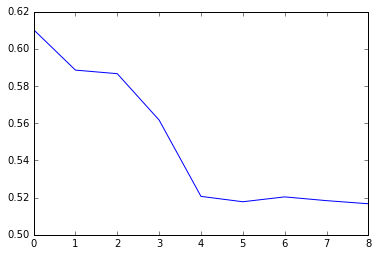

In [13]:
plt.plot(training_losses)